In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
sns.set(rc={'figure.figsize': (9, 6)})

In [5]:
titanic_data = pd.read_csv('titanic/train.csv')

In [6]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic_data.Survived

In [9]:
X = pd.get_dummies(X)

In [10]:
X = X.fillna({'Age': X.Age.median()})

In [11]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [12]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [15]:
clf.score(X_test, y_test)

0.7796610169491526

In [16]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [17]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [18]:
clf.score(X_test, y_test)

0.8067796610169492

In [19]:
max_depth_values = range(1, 100)

In [33]:
scores = pd.DataFrame()

In [34]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    scores = pd.concat([
        scores,
        pd.DataFrame({
            'max_depth': [max_depth],
            'train_score': [train_score],
            'test_score': [test_score],
            'cross_val_score': [mean_cross_val_score]
        }),
    ], ignore_index=True)

In [35]:
scores.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
1,2,0.805369,0.776271,0.770196
2,3,0.823826,0.820339,0.790322
3,4,0.833893,0.823729,0.788627
4,5,0.840604,0.806780,0.802073


In [40]:
scores_data_long = pd.melt(scores,
        id_vars=['max_depth'],
        value_vars=['train_score', 'test_score', 'cross_val_score'],
        var_name='set_type',
        value_name='score'
        )

In [43]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


<AxesSubplot:xlabel='max_depth', ylabel='score'>

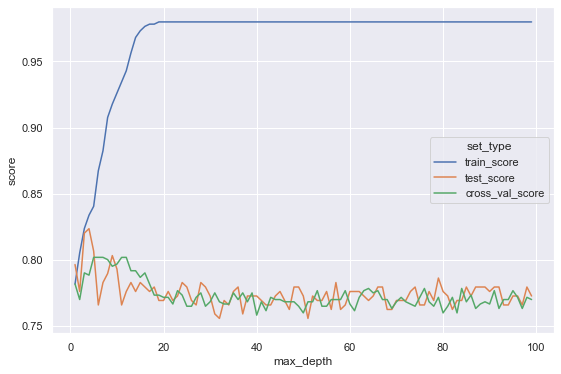

In [44]:
sns.lineplot(data=scores_data_long, x='max_depth', y='score', hue='set_type')

In [45]:
scores_data_long.query('set_type == "cross_val_score"').head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.802073
203,6,cross_val_score,0.802073
204,7,cross_val_score,0.802059
205,8,cross_val_score,0.800364
206,9,cross_val_score,0.795308
207,10,cross_val_score,0.796989


In [48]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [49]:
cross_val_score(clf, X_test, y_test, cv=5).mean()

0.7932203389830509

In [33]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = titanic_data.Survived

In [34]:
X = pd.get_dummies(X)

In [35]:
X = X.fillna({'Age': X.Age.median()})

In [36]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [37]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

[Text(144.2400418526786, 212.004, 'X[6] <= 0.5\nentropy = 0.961\nsamples = 891\nvalue = [549, 342]'),
 Text(54.03133928571429, 201.132, 'X[0] <= 2.5\nentropy = 0.824\nsamples = 314\nvalue = [81, 233]'),
 Text(20.327142857142857, 190.26, 'X[4] <= 28.856\nentropy = 0.299\nsamples = 170\nvalue = [9, 161]'),
 Text(15.544285714285714, 179.388, 'X[4] <= 28.231\nentropy = 0.469\nsamples = 70\nvalue = [7, 63]'),
 Text(13.152857142857144, 168.516, 'X[1] <= 23.5\nentropy = 0.426\nsamples = 69\nvalue = [6, 63]'),
 Text(10.76142857142857, 157.644, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(15.544285714285714, 157.644, 'X[1] <= 27.5\nentropy = 0.503\nsamples = 54\nvalue = [6, 48]'),
 Text(9.565714285714286, 146.772, 'X[1] <= 25.5\nentropy = 0.845\nsamples = 11\nvalue = [3, 8]'),
 Text(4.782857142857143, 135.9, 'X[4] <= 13.75\nentropy = 0.592\nsamples = 7\nvalue = [1, 6]'),
 Text(2.3914285714285715, 125.02799999999999, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(7.17428571428571

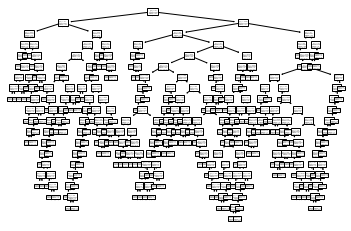

In [38]:
tree.plot_tree(clf)